In [231]:
import json
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib import cm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [232]:
infile = open('FEM_converted.json', 'r')

In [233]:
var_dict = json.load(infile)

In [234]:
infile.close()

In [235]:
nnode = var_dict["nnode"]
xcoord = np.asarray([i[0] for i in var_dict["coord"]])
ycoord = np.asarray([i[1] for i in var_dict["coord"]])
nelem = var_dict["nelem"]
connect = var_dict["connect"]
nfix = var_dict["nfix"]
fixnodes = var_dict["fixnodes"]
ndload = var_dict["ndload"]
dloads = var_dict["dloads"]

In [236]:
def create_Dmat(E, nu):
    return (E/((1+nu)*(1-2*nu))) * torch.tensor([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2]])

In [237]:
def elresid(xa, ya, xb, yb, tx, ty):
    length = np.sqrt((xa-xb)*(xa-xb)+(ya-yb)*(ya-yb))
    return torch.tensor([tx,ty,tx,ty])*length/2

In [238]:
def elstif(xa,ya,xb,yb,xc,yc,Dmat):
    # Define B matrix
    nax = -(yc-yb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nay =  (xc-xb)/( (ya-yb)*(xc-xb) - (xa-xb)*(yc-yb) )
    nbx = -(ya-yc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    nby =  (xa-xc)/( (yb-yc)*(xa-xc) - (xb-xc)*(ya-yc) )
    ncx = -(yb-ya)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    ncy =  (xb-xa)/( (yc-ya)*(xb-xa) - (xc-xa)*(yb-ya) )
    area = (1/2)*np.abs( (xb-xa)*(yc-ya) - (xc-xa)*(yb-ya) )
    Bmat = torch.tensor([[nax, 0, nbx, 0, ncx, 0],
                        [0, nay, 0, nby, 0, ncy],
                        [nay, nax, nby, nbx, ncy, ncx]])
    
    # Return element stiffness
    return torch.tensor(area*np.dot(np.dot(torch.transpose(Bmat, 0, 1), Dmat), Bmat))

In [239]:
class uFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)

        E_st = 200
        nu_st = 0.3
        E_al = 69
        nu_al = 0.33

        Stif = torch.zeros((2*nnode, 2*nnode))

        for lmn in range(nelem):
            a = connect[lmn][0]
            b = connect[lmn][1]
            c = connect[lmn][2]

            if input[lmn] > 0.5:
                Dmat = create_Dmat(E_st, nu_st)
                k = elstif(xcoord[a], ycoord[a],
                            xcoord[b], ycoord[b],
                            xcoord[c], ycoord[c], Dmat)
            else:
                Dmat = create_Dmat(E_al, nu_al)
                k = elstif(xcoord[a], ycoord[a],
                            xcoord[b], ycoord[b],
                            xcoord[c], ycoord[c], Dmat)

            for i in range(3):
                for ii in range(2):
                    for j in range(3):
                        for jj in range(2):
                            rw = 2*(connect[lmn][i])+ii
                            cl = 2*(connect[lmn][j])+jj
                            with torch.no_grad():
                                Stif[rw][cl] = Stif[rw][cl] + k[2*i+ii][2*j+jj]
        
        resid = torch.zeros(2*nnode)

        pointer = [1, 2, 0]
        for i in range(ndload):
            lmn = dloads[i][0]
            face = dloads[i][1]
            a = connect[lmn][face]
            b = connect[lmn][pointer[face]]
            r = elresid(xcoord[a], ycoord[a],
                        xcoord[b], ycoord[b],
                        dloads[i][2], dloads[i][3])
            
            resid[2*a]=resid[2*a]+r[0]
            resid[2*a+1]=resid[2*a+1]+r[1]
            resid[2*b]=resid[2*b]+r[2]
            resid[2*b+1]=resid[2*b+1]+r[3]

        for i in range(nfix):
            rw=2*(fixnodes[i][0]) + fixnodes[i][1]
            for j in range(2*nnode):
                Stif[rw][j] = 0
            Stif[rw][rw] = 1.0
            resid[rw] = fixnodes[i][2]

        u = torch.linalg.solve(Stif, resid)
        
        return u
    
    @staticmethod
    def backward(ctx, grad_output):
        print(grad_output)
        input = ctx.saved_tensors
        if ctx.needs_input_grad[0]:
            grad_input = torch.zeros(nelem)
            for i in range(nelem):
                grad_input[i] = (grad_output[connect[i][0]] + grad_output[connect[i][0] + 1] +
                                grad_output[connect[i][1]] + grad_output[connect[i][1] + 1] +
                                grad_output[connect[i][2]] + grad_output[connect[i][2] + 1]) / 6
        
        return grad_input

In [240]:
class weightFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        
        elem_weight = torch.zeros(nelem)

        # Define what each element is made of (steel or aluminum)
        for lmn in range(nelem):
            # > 0.5 == aluminum
            if input[lmn] > 0.5:
                elem_weight[lmn] = 0.00783
            else:
                elem_weight[lmn] = 0.0027
        
        return elem_weight
    
    def backward(ctx, grad_output):
        print(grad_output)
        return grad_output * 10

In [241]:
createU = uFunction.apply
genWeights = weightFunction.apply

In [242]:
class steelAlNet(nn.Module):
    def __init__(self):
        super(steelAlNet, self).__init__()
        torch.manual_seed(12)
        self.elem_material = nn.Parameter(torch.rand(nelem), requires_grad=True)

    def forward(self):
        # Create customized NN layer
        #   input: Stif, resid
        #   output: u
        # Need to implement forward() and backward()
        #   forward() is essentially np.linalg.solve()
        #   backward()
        #       input: partial derivative of loss function with respect to u
        #       output: partial derivative of loss / input
        elem_weights = genWeights(self.elem_material)
        u = createU(self.elem_material)
    
        return self.elem_material, elem_weights, u


In [243]:
net = steelAlNet()
elem_material, elem_weights, u = net()

In [244]:
def displayPlot(elem_material, u):
    uxcoord = [0] * nnode
    uycoord = [0] * nnode
    for i in range(nnode):
        uxcoord[i] = xcoord[i] + u[2*i].item()
        uycoord[i] = ycoord[i] + u[2*i+1].item()

    facecolors = [0] * nelem

    for lmn in range(nelem):
        if elem_material[lmn] > 0.5:
            facecolors[lmn] = 0
        else:
            facecolors[lmn] = 1
    
    fig, ax = plt.subplots()
    triang = mtri.Triangulation(xcoord, ycoord, connect)
    triang2 = mtri.Triangulation(uxcoord, uycoord, connect)
    plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='green', linewidth=2, cmap='Greys', alpha=0.5)
    plt.tripcolor(triang2, ax, facecolors=facecolors, edgecolors='r', linewidth=2, cmap='Greys', alpha=0.5)

Parameter containing:
tensor([0.4657, 0.2328, 0.4527, 0.5871, 0.4086, 0.1272, 0.6373, 0.2421, 0.7312,
        0.7224, 0.1992, 0.6948, 0.5830, 0.6318, 0.5559, 0.1262, 0.9790, 0.8443,
        0.1256, 0.4456, 0.6601, 0.0554, 0.1573, 0.8137, 0.7216, 0.2717, 0.3003,
        0.6099, 0.5784, 0.6083, 0.4339, 0.8813, 0.3216, 0.2604, 0.2566, 0.1872,
        0.6423, 0.1786, 0.1435, 0.7490, 0.7275, 0.1641, 0.3273, 0.1239, 0.6138,
        0.4535, 0.7659, 0.1800, 0.3338, 0.9526, 0.8919, 0.9859, 0.6348, 0.8811,
        0.9391, 0.1173, 0.1342, 0.9405, 0.6803, 0.5556, 0.8713, 0.0782, 0.8578,
        0.7540, 0.6698, 0.5817, 0.3829, 0.7163, 0.8930, 0.5597, 0.2803, 0.2476,
        0.4738, 0.1306, 0.2024, 0.6387, 0.0999, 0.9615, 0.5350, 0.7141, 0.5617,
        0.0932, 0.7554, 0.2457, 0.4564, 0.7554, 0.4248, 0.8840, 0.3281, 0.8162,
        0.5574, 0.8026, 0.5661, 0.2665, 0.6731, 0.6549, 0.1701, 0.1122, 0.0031,
        0.9943, 0.5738, 0.5591, 0.5253, 0.3021, 0.8672, 0.8205, 0.1444, 0.7116,
        0.8435, 0.

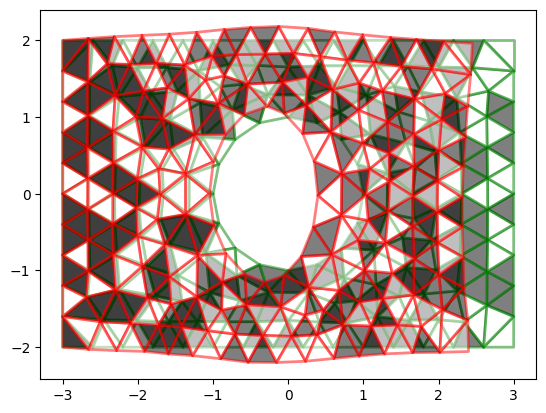

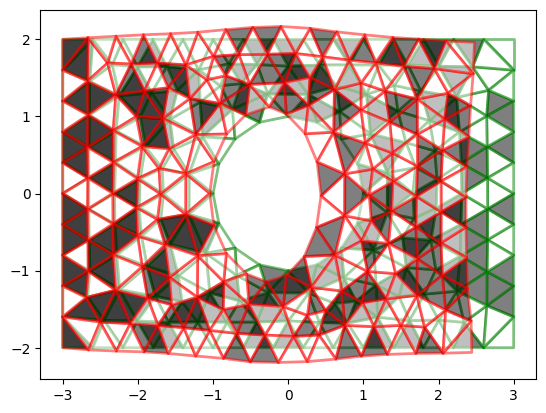

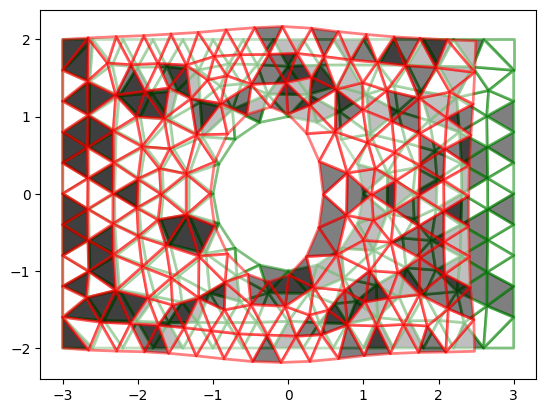

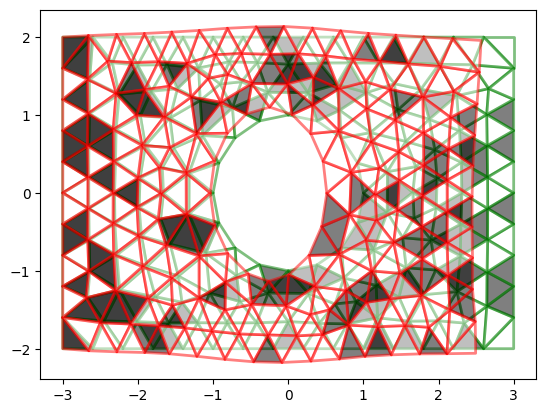

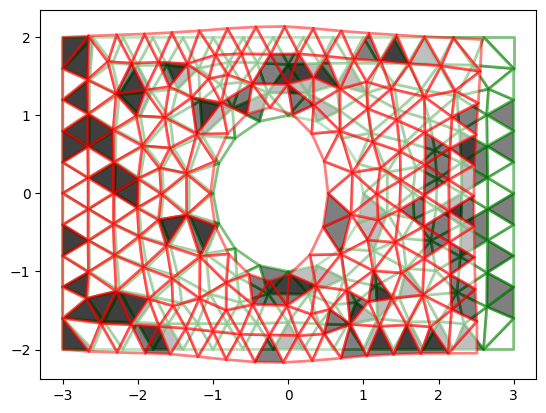

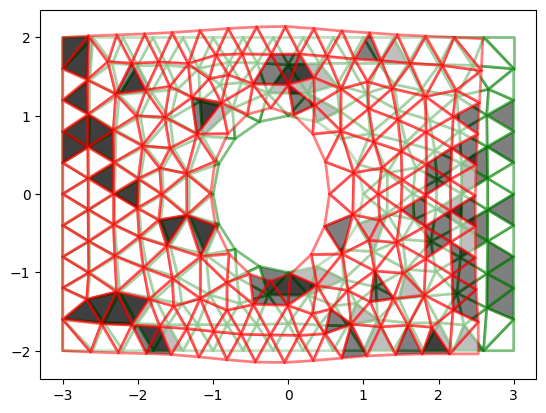

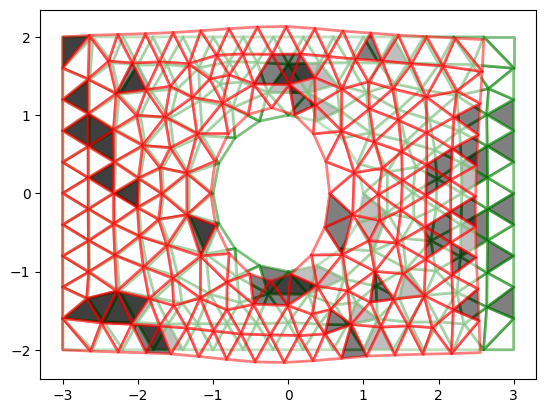

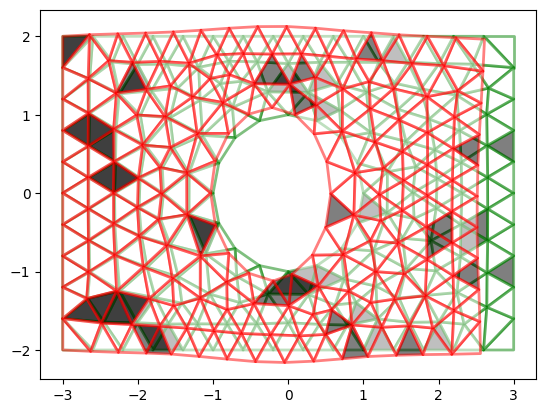

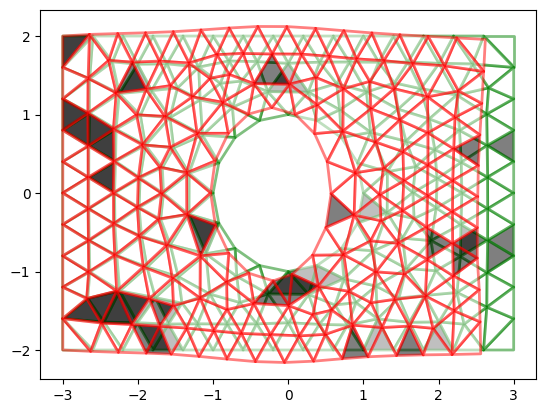

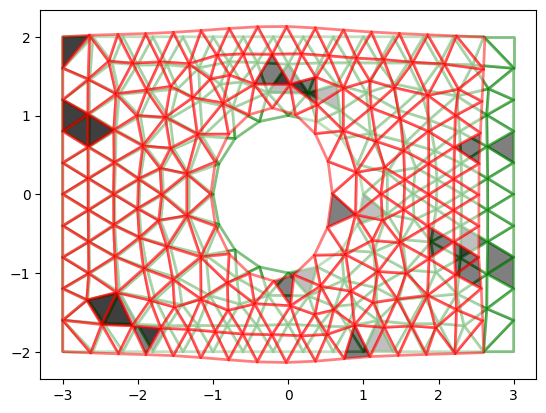

In [245]:
num_epochs = 10
learning_rate = 100
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)

ideal_weights = torch.tensor([0.0027] * nelem)
ideal_u = torch.tensor([0.0] * 2 * nnode)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    elem_material, elem_weights, u = net()

    print(elem_material)

    displayPlot(elem_material, u)

    loss = loss_fn(u, ideal_u)
    loss.backward()

    loss2 = loss_fn(elem_weights, ideal_weights)
    loss2.backward()

    for name, param in net.named_parameters():
        if param.requires_grad:
            print(name, param.grad)

    optimizer.step()

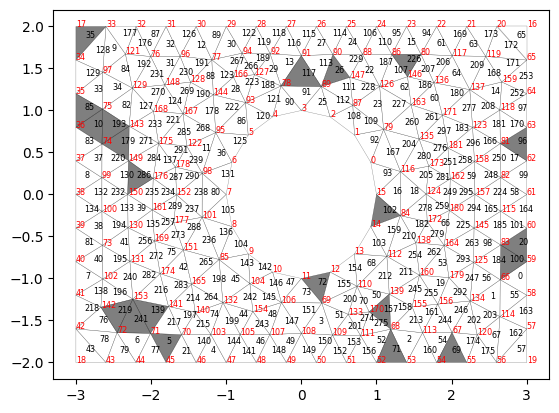

In [246]:
elem_material, elem_weights, u = net()

facecolors = [0] * nelem

for lmn in range(nelem):
    if elem_material[lmn] > 0.5:
        facecolors[lmn] = 0
    else:
        facecolors[lmn] = 1

fig, ax = plt.subplots()
triang = mtri.Triangulation(xcoord, ycoord, connect)
plt.tripcolor(triang, ax, facecolors=facecolors, edgecolors='k', cmap='Greys', alpha=0.5)
for i in range(nnode):
    plt.text(xcoord[i], ycoord[i], i, color='r', size='xx-small')
for i in range(nelem):
    n1, n2, n3 = connect[i]
    avgx = (xcoord[n1] + xcoord[n2] + xcoord[n3]) / 3
    avgy = (ycoord[n1] + ycoord[n2] + ycoord[n3]) / 3
    plt.text(avgx, avgy, i, size='xx-small')